In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

from evodcinv import EarthModel, Layer, Curve
import torch
from torch.utils import data
from utils import *
from scipy.interpolate import griddata

from torch_utils import *
%config InlineBackend.figure_formats = ['png']
plt.style.use('seaborn-whitegrid')

# Run the inference

In [2]:
testing_data_path = '../dataset/test_example_multimode_v2/data_su/'
labels_path = '../dataset/test_example_multimode_v2/label/'
model_path = './model_multimode.pt'

files = glob.glob(testing_data_path+'*.su')

In [3]:
# total depth
sizez = 50

# receiver axis
nx = 24
dx = 1
ox = 15

# time axis
t0 = 0.23
dt = 0.0005
nt = 1999

# velocities and frequencies for dispersion panels
cmin = 5
cmax = 2000
dc = 1.0
fmin = 5
fmax = 70
nperiod = 500 # number of samples in period/freq axis

x = np.arange(nx)*dx + ox
t = np.arange(nt)*dt
freq_fm = np.linspace(fmin, 60, nperiod)
period = np.linspace(1/60, 0.2, nperiod)

In [4]:
idx = [-1, -2]
testing_data = []
testing_label = []
up=[]

for m in range(150):
    filename = str(m) + '_rvz.su'
    traces = read(testing_data_path+filename)

    for tt in range(len(traces)):
        traces[tt].data = cn(traces[tt].data, 3)  # add noise

        traces[tt] = traces[tt].trim(
            traces[tt].stats.starttime+t0, traces[tt].stats.starttime+t0+0.4)  # adjust time axis

    u = traces[0:len(traces)]
    unp = np.zeros((len(u), u[0].stats.npts), dtype='float32')
    
    for uu in range(len(u)):
        unp[uu] = u[uu].data
    up.append(u)
    testing_data.append(np.delete(unp, idx, 1))
    testing_label.append(
        np.load(labels_path + str(m) + '_label.npy'))

In [5]:
srcs = np.arange(1, 300, 2)
midarray = srcs + 19.5

In [6]:
# Normalize
testing_data_norm = []
for k in range(len(testing_data)):
    testing_d_norm = testing_data[k] / \
        testing_data[k].max(axis=1)[:, np.newaxis]
    testing_data_norm.append(testing_d_norm)

In [7]:
testing_data_tensor = torch.Tensor(testing_data_norm)
testing_data_tensor = testing_data_tensor.reshape(testing_data_tensor.shape[0], 1, 
                                                  testing_data_tensor.shape[1], 
                                                  testing_data_tensor.shape[2])
testing_dataset = data.TensorDataset(testing_data_tensor)

batch_size = 1
testing_loader = data.DataLoader(dataset=testing_dataset, batch_size=batch_size, num_workers=0)

In [8]:
device = torch.device('cpu')
model_eval = torch.load(model_path).to(device)
model_eval.eval()

outputs_list = []
for bs, (shot_gathers) in enumerate(tqdm(testing_loader)):
    outputs = model_eval(shot_gathers[0])
    outputs_list.append(outputs.detach().numpy())

100%|██████████| 150/150 [00:01<00:00, 87.40it/s]


# Perform inversion

In [9]:
models = []

for i in range(150):

    # Initialize model
    model = EarthModel()

    # Build model search boundaries from top to bottom
    # First argument is the bounds of layer's thickness [km]
    # Second argument is the bounds of layer's S-wave velocity [km/s]

    model.add(Layer([0.001, 0.02], [0.1, 0.5]))
    model.add(Layer([0.001, 0.02], [0.3, 0.7]))
    model.add(Layer([0.001, 0.02], [0.4, 0.8]))
    model.add(Layer([0.001, 0.02], [0.5, 0.9]))
    model.add(Layer([0.001, 0.02], [0.6, 1.3]))

    # Configure model
    model.configure(
        optimizer="cpso",  # Evolutionary algorithm
        misfit="rmse",  # Misfit function type
        density=lambda vp: 2.0,
        optimizer_args={
            "popsize": 10,  # Population size
            "maxiter": 80,  # Number of iterations
            "workers": -1,  # Number of cores
            "seed": 0,
        },
    )

    # Define the dispersion curves to invert
    # period and velocity are assumed to be data arrays

    # FOR FUNDAMENTAL AND FIRST MODE IMPLEMENTATION ----------
    cpvel = testing_label[i][:500:10]/1000
    #cpvel = outputs_list[i][0][:500:10]/1000
    f = np.linspace(5.0, 60.0, len(cpvel))
    # period = #1.0 / f[::-1]
    period = np.linspace(1/60, 1/5, len(cpvel))

#    fmvel = outputs_list[i][0][500::10]/1000
    fmvel = testing_label[i][500::10]/1000
    fmf = np.linspace(15.0, 60.0, len(fmvel))
    #fmperiod = 1.0 / fmf[::-1]
    fmperiod = np.linspace(1/60, 1/15, len(fmvel))


    # # FOR ONLY FUNDAMENTAL MODE -----------------
    # cpvel = outputs_list[i][0][::-10]/1000
    # f = np.linspace(5.0, 60.0, len(cpvel))
    # period = 1 / f[::-1]
    
    # cpvel = velss[i][::-1]/1000
    # f = freqss[i]
    # period = 1.0 / f[::-1]

    curves = [Curve(period, cpvel, 0, "rayleigh", "phase"), Curve(fmperiod, fmvel, 1, "rayleigh", "phase")]

    # Run inversion
    res = model.invert(curves)
    models.append(res.model)

Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0152
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0108
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0202
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0135
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0166
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0137
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0155
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0141
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0141
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0160
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0161
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0092
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0067
Run 1 |████████████████████| 100% [0:00:01 / 0:00:00] - Misfit: 0.0095
Run 1 

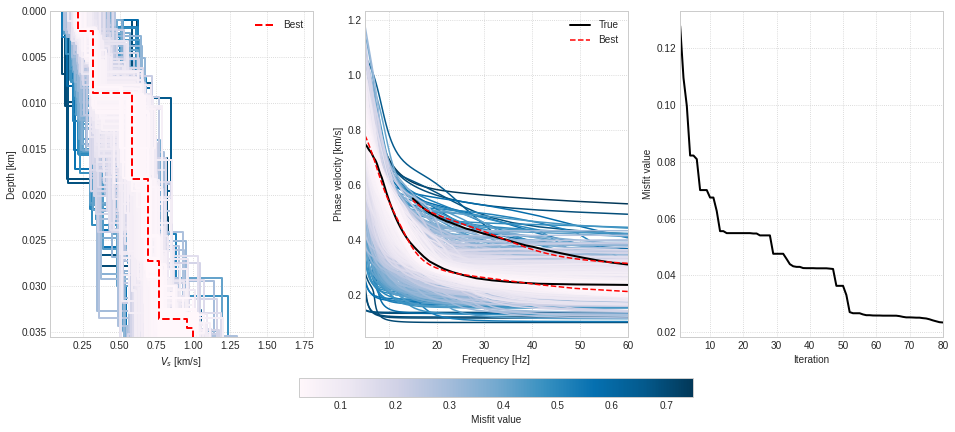

In [11]:
# Plot results
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for a in ax:
    a.grid(True, linestyle=":")

zmax = 0.1
cmap = "PuBu"

# Velocity model
res.plot_model("vs", show="all", ax=ax[0], plot_args={"cmap": cmap})

res.plot_model("vs", show="best", ax=ax[0],
        plot_args={
        "color": "red",
        "linestyle": "--",
        "label": "Best"})

ax[0].legend(loc=1, frameon=False)

# Dispersion curve
res.plot_curve(period, 0, "rayleigh", "phase", show="all", ax=ax[1],
    plot_args={
        "xaxis": "frequency",
        "cmap": cmap})

ax[1].plot(1/np.linspace(1/60, 1/15, 50), fmvel, color="black", linewidth=2, label="True")

ax[1].plot(1/np.linspace(1/60, 1/5, 50), cpvel, color="black", linewidth=2)

#ax[1].plot(np.linspace(5, 60, 50), cpvel[::-1], color="black", linewidth=2)

res.plot_curve(period, 0, "rayleigh", "phase", show="best", ax=ax[1],
    plot_args={
        "xaxis": "frequency",
        "color": "red",
        "linestyle": "--",
        "label": "Best"})

res.plot_curve(fmperiod, 1, "rayleigh", "phase", show="best", ax=ax[1],
    plot_args={
        "xaxis": "frequency",
        "color": "red",
        "linestyle": "--"})

ax[1].set_xlim(5.0, 60.0)
ax[1].xaxis.set_major_formatter(ScalarFormatter())
ax[1].xaxis.set_minor_formatter(ScalarFormatter())
ax[1].legend(loc=1, frameon=False)

# Misfit
res.plot_misfit(ax=ax[2])

# Colorbar
norm = Normalize(vmin=res.misfits.min(), vmax=res.misfits.max())
smap = ScalarMappable(norm=norm, cmap=cmap)
axins = inset_axes(
    ax[1],
    width="150%",
    height="6%",
    loc="lower center",
    borderpad=-6.0,
)

cb = plt.colorbar(smap, cax=axins, orientation="horizontal")
cb.set_label("Misfit value")

plt.show()

In [31]:
ma = np.array(midarray)

In [40]:
x = []
y = []
velsfin = []

for i in range(150):
    x.extend([midarray[i]]*(models[0].shape[0]+1))   #adds 4 values for x
 
    mod = models[i]

    depths = [0] #first value is 0 depth
    depths.append(mod[0][0]) #next value is next depth

    vels = []
    vels.append(mod[0][2]) #adds first vel value to z=0 #adds first vel value to the depth of the boundary

    for i in range(models[0].shape[0]-1):
        depths.append(mod[i][0]+mod[i+1][0])
        
    for i in range(models[0].shape[0]):
        vels.append(mod[i][2])

    depths_m = [dp*1000 for dp in depths]
    vels_m = [vl*1000 for vl in vels]

    y.extend(depths_m)
    velsfin.extend(vels_m)

xnew = np.arange(min(x),max(x),5)
ynew =  np.arange(min(y),max(y),5)
X, Y = np.meshgrid(xnew,ynew)

Ti = griddata((x,y), velsfin, (X, Y), method='linear')


In [10]:
import numpy as np
from scipy.interpolate import griddata

depth_interval = 0.0025

x = []
y = []
velsfin = []

for i in range(129):
    mod = models[i]

    thicknesses = [0] + mod[:, 0].tolist()  # Extract layer thicknesses from the model
    vels = [mod[0, 2]] + mod[:, 2].tolist()  # Extract velocities from the model

    # Calculate the depth boundaries based on the cumulative sum of the thickness values
    depths = [0] + np.cumsum(thicknesses).tolist()

    depths_fine = []
    vels_fine = []

    # Iterate through depth intervals
    for j in range(len(depths) - 1):
        # Create a new depth array within the interval with finer sampling
        depths_interval = np.arange(depths[j], depths[j + 1], depth_interval)

        depths_fine.extend(depths_interval)
        # Repeat the velocity value within the interval
        vels_fine.extend([vels[j]] * len(depths_interval))

    depths_m = [dp * 1000 for dp in depths_fine]
    vels_m = [vl * 1000 for vl in vels_fine]

    for j in range(len(depths_m)):
        x.append(midarray[i])
        y.append(depths_m[j])
        velsfin.append(vels_m[j])

xnew = np.arange(min(x), max(x), 5)
ynew = np.arange(min(y), max(y), 5)
X, Y = np.meshgrid(xnew, ynew)

Ti = griddata((x, y), velsfin, (X, Y), method='linear')


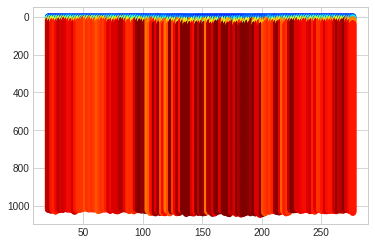

In [13]:
plt.gca().invert_yaxis()
plt.scatter(x, y, c=velsfin, cmap='jet', vmin=100, vmax=1000)

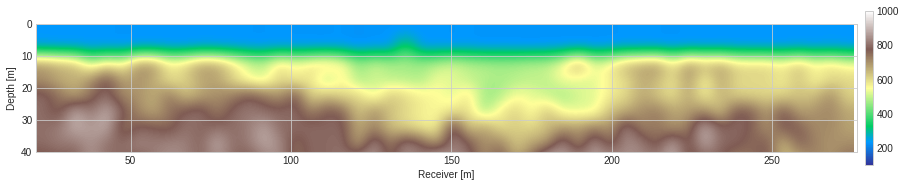

In [11]:
plt.figure(figsize=(15,4))

im = plt.imshow(Ti, extent=(min(xnew), max(xnew), min(ynew), max(ynew)), aspect='equal',cmap='terrain', interpolation='bicubic', origin='lower', vmin=100, vmax=1000)
#plt.scatter(x, y, c=velsfin, vmin=100, vmax=1000, marker='o', cmap='terrain')
plt.gca().invert_yaxis()

plt.ylim(40, min(y))
plt.xlim(min(x), max(x))

plt.xlabel('Receiver [m]')
plt.ylabel('Depth [m]')

plt.colorbar(im,fraction=0.046*1/5, pad=0.01)


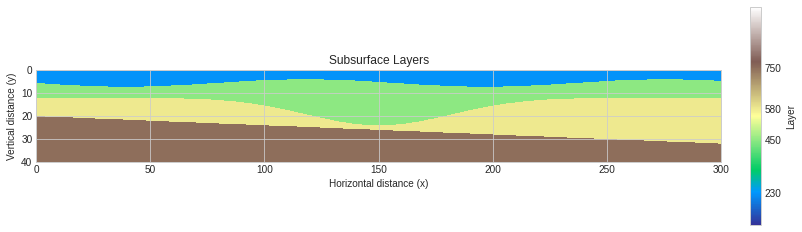

In [24]:
# Define the boundaries
_x = np.arange(0, 300, 0.1)
_y = np.arange(0, 50, 0.1)
y = lambda x: 7 + 2*np.sin(x/25)
y2 = lambda x: 15 + 15*np.exp(-(150-x)**2/2000)
y3 = lambda x: 25 + x/20

# Create a 2D grid
X, Y = np.meshgrid(_x, _y)

# Create masked arrays based on the boundary functions
mask1 = Y <= y(X)
mask2 = np.logical_and(Y > y(X), Y <= y2(X))
mask3 = np.logical_and(Y > y2(X), Y <= y3(X))
mask4 = Y > y3(X)

# Create the final 2D grid using the masked arrays
Z = np.zeros(X.shape)
Z[mask1] = 230
Z[mask2] = 450
Z[mask3] = 580
Z[mask4] = 750

# Define a colormap with discrete colors for the layers
cmap = plt.cm.get_cmap('terrain')

# Plot the resulting grid
plt.figure(figsize=(13, 6))
plt.imshow(Z, extent=[0, 300, 40, 0], cmap=cmap, interpolation='none', vmin=100, vmax=1000)
plt.xlabel('Horizontal distance (x)')
plt.ylabel('Vertical distance (y)')
plt.title('Subsurface Layers')
plt.colorbar(ticks=[450, 230, 580, 750], label='Layer', cmap=cmap, fraction=0.015, pad=0.04)
plt.show()
